# Classification problem
### Considering binary gender classification
(0) Male

(1) Female

In [10]:
%cd /Users/rodrigo/Post-Grad/CC400/Repo

/Users/rodrigo/Post-Grad/CC400/Repo


In [11]:
import utils

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold



%matplotlib inline
sns.set(rc={'image.cmap': 'coolwarm'})

#from numba import jit,prange

import time
import os

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_macro': 'recall_macro',
          'f1' : 'f1_macro',
          'roc_auc' : 'roc_auc'} 

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

results = pd.DataFrame()

In [13]:
def import_data(fisher):
    if fisher == True:
        df = pd.read_csv(r'/Users/rodrigo/Post-Grad/CC400/corr_matrices_fisher200.csv',index_col=['Institution','Subject'])
        phenotypic = pd.read_csv(r'/Users/rodrigo/Post-Grad/CC400/phenotypic200.csv',index_col=['Institution','Subject'])
    else:
        df = pd.read_csv(r'/Users/rodrigo/Post-Grad/CC400/corr_matrices200.csv',index_col=['Institution','Subject','Run'])
        phenotypic = pd.read_csv(r'/Users/rodrigo/Post-Grad/CC400/phenotypic200.csv',index_col=['Institution','Subject'])
    return df,phenotypic

In [14]:
df, phenotypic = import_data(fisher=True)
df = df.join(pd.DataFrame(phenotypic.Age), how='left')
df = df.join(pd.DataFrame(phenotypic['ADHD Measure']), how='left')
df = df.join(pd.DataFrame(phenotypic['Gender']), how='left')

#df = ((df.reset_index()).drop(columns=['Institution', 'Subject','Run'])).dropna(subset=[str(x) for x in range(0,61425)])
df = ((df.reset_index()).drop(columns=['Institution', 'Subject'])).dropna(subset=[str(x) for x in range(0,17954)])
df = df.dropna(axis=0, subset=['Gender'])

from sklearn.utils import shuffle
df = shuffle(df, random_state=42)

# Real test set
TEST =  df.iloc[-30:]

df = df.iloc[:-30]

y = (df.Gender).apply(lambda x: int(x))

# Remove from Fisher-space
X = np.tanh(df.iloc[:,:-3])
X_TEST =  np.tanh(TEST.iloc[:,:-3])
y_TEST =  (TEST.Gender).apply(lambda x: int(x))

X[X <= 0] = 0
X_TEST[X_TEST <= 0] = 0

In [15]:
ROI_labels = pd.read_csv('/Users/rodrigo/Post-Grad/CC400/ROI_labels.csv')

In [16]:
print(' 0 = {:.2f}% \n'.format(y.value_counts()[0]/len(y)), '1 = {:.2f}%'.format(y.value_counts()[1]/len(y)))

 0 = 0.37% 
 1 = 0.63%


In [17]:
from sklearn.model_selection import train_test_split

# Validation and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15,shuffle=True, random_state=42)


In [18]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_test, y_test)

# Make predictions on the testing data
pred_y = dummy.predict(X_test)

scores = cross_validate(dummy, X, y, cv=cv, scoring=scoring)

print("Accuracy in test:%0.2f(%0.2f)" % (scores['test_acc'].mean(), scores['test_acc'].std()))
print("F1_scores {:.2f}({:.2f})".format(scores['test_f1'].mean(), scores['test_f1'].std()))
print("Precision_scores {:.2f}({:.2f})".format(scores['test_prec_macro'].mean(), scores['test_prec_macro'].std()))
print("Recall_scores {:.2f}({:.2f})".format(scores['test_rec_macro'].mean(), scores['test_rec_macro'].std()))
print("ROC AUC {:.2f}({:.2f})".format(scores['test_roc_auc'].mean(), scores['test_roc_auc'].std()))
print('Dummy accuracy score in TEST set: {0:0.4f}'. format(accuracy_score(y_TEST, dummy.predict(X_TEST))))

Accuracy in test:0.63(0.00)
F1_scores 0.39(0.00)
Precision_scores 0.31(0.00)
Recall_scores 0.50(0.00)
ROC AUC 0.50(0.00)
Dummy accuracy score in TEST set: 0.6000


/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

### Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Logistic Regression accuracy score in training set: {0:0.4f}'. format(accuracy_score(y_train, logreg.predict(X_train))))
print('Logistic Regression accuracy score in val set: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print('Logistic Regression accuracy score in TEST set: {0:0.4f}'. format(accuracy_score(y_TEST, logreg.predict(X_TEST))))

Logistic Regression accuracy score in training set: 1.0000
Logistic Regression accuracy score in val set: 0.7706
Logistic Regression accuracy score in TEST set: 0.8000


/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


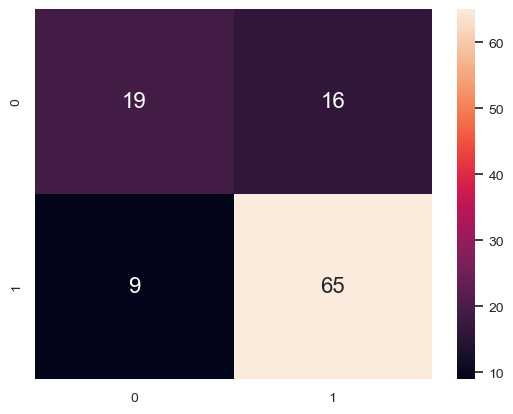

In [20]:
plt.figure(dpi=100)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, annot_kws={"size": 16}, fmt='g')
plt.show()

### Cross Validation

In [21]:
scores = cross_validate(logreg, X, y, cv=cv, scoring=scoring, n_jobs=-1)

print("Accuracy in test:%0.2f(%0.2f)" % (scores['test_acc'].mean(), scores['test_acc'].std()))
print("F1_scores {:.2f}({:.2f})".format(scores['test_f1'].mean(), scores['test_f1'].std()))
print("Precision_scores {:.2f}({:.2f})".format(scores['test_prec_macro'].mean(), scores['test_prec_macro'].std()))
print("Recall_scores {:.2f}({:.2f})".format(scores['test_rec_macro'].mean(), scores['test_rec_macro'].std()))
print("ROC AUC {:.2f}({:.2f})".format(scores['test_roc_auc'].mean(), scores['test_roc_auc'].std()))

/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

Accuracy in test:0.72(0.07)
F1_scores 0.69(0.07)
Precision_scores 0.71(0.08)
Recall_scores 0.68(0.06)
ROC AUC 0.77(0.08)


In [22]:
scores['Model'] = ['logreg']*10
results = pd.concat([results, pd.DataFrame.from_dict(scores)],axis=1)

In [23]:
logreg.fit(X,y)
print('Accuracy score in TEST set: {0:0.4f}'. format(accuracy_score(y_TEST, logreg.predict(X_TEST))))

Accuracy score in TEST set: 0.8667


/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
y_score = logreg.predict_proba(X_TEST)

y_score = y_score[:,1]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_TEST, y_score)
roc_auc = auc(fpr, tpr)

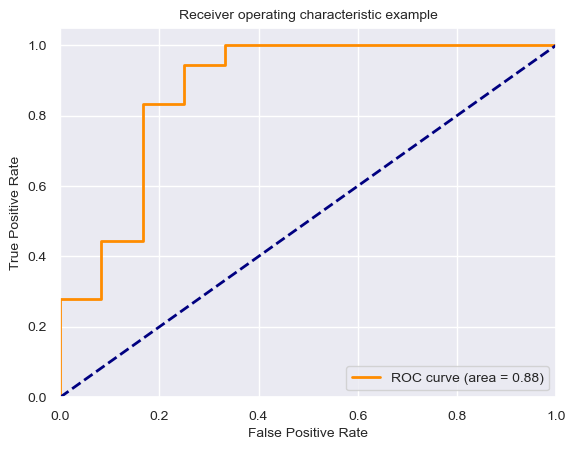

In [25]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

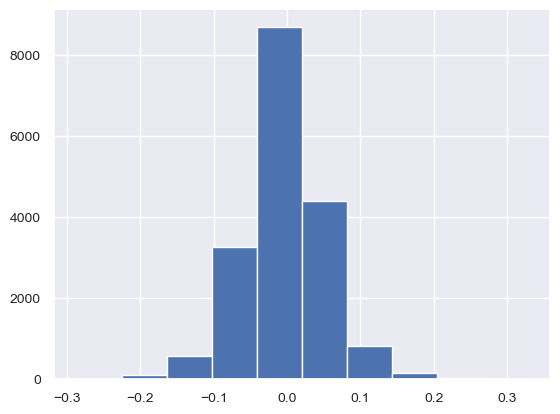

In [26]:
# get importance
importance = logreg.coef_[0]
importance = np.sort(importance)

plt.hist(importance)
plt.show()

## SVM

In [27]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Setting possible values for the multiple hyperparameters of XGBoost
random_grid = {
    "C": [0, 0.25, 1, 5, 10],
    "kernel" : ['linear', 'poly', 'rbf', 'sigmoid']
}


svc = SVC(gamma='auto')
#svc.fit(X_train, y_train)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations
rf_random = GridSearchCV(estimator = svc, param_grid = random_grid,
                               cv = 3, verbose=1, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train.values.ravel())

#y_pred = svc.predict(X_test)

#print('Logistic Regression accuracy score in training set: {0:0.4f}'. format(accuracy_score(y_train, logreg.predict(X_train))))
#print('Logistic Regression accuracy score in test set: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
12 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/svm/_base.py", line 180, in fit
    self._validate_params()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/si

GridSearchCV(cv=3, estimator=SVC(gamma='auto'), n_jobs=-1,
             param_grid={'C': [0, 0.25, 1, 5, 10],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             verbose=1)

In [28]:
accuracy = rf_random.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Accuracy for our training dataset with tuning is : 71.64%


In [29]:
print(rf_random.best_params_)
(pd.DataFrame.from_dict(rf_random.best_params_, orient='index')).to_csv('/Users/rodrigo/Post-Grad/CC400/Results/SVC_params.csv')

{'C': 0.25, 'kernel': 'linear'}


In [30]:
# Best SVC model
svc = SVC(
    **rf_random.best_params_,
    gamma="auto"
)

scores = cross_validate(svc, X_train, y_train.values.ravel(), scoring=scoring,
                         cv=cv, n_jobs=-1,verbose=1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   10.9s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   13.7s finished


In [31]:
print("Accuracy in test:%0.2f(%0.2f)" % (scores['test_acc'].mean(), scores['test_acc'].std()))
print("F1_scores {:.2f}({:.2f})".format(scores['test_f1'].mean(), scores['test_f1'].std()))
print("Precision_scores {:.2f}({:.2f})".format(scores['test_prec_macro'].mean(), scores['test_prec_macro'].std()))
print("Recall_scores {:.2f}({:.2f})".format(scores['test_rec_macro'].mean(), scores['test_rec_macro'].std()))
print("ROC AUC {:.2f}({:.2f})".format(scores['test_roc_auc'].mean(), scores['test_roc_auc'].std()))

Accuracy in test:0.73(0.04)
F1_scores 0.70(0.05)
Precision_scores 0.72(0.05)
Recall_scores 0.70(0.05)
ROC AUC 0.76(0.05)


In [32]:
scores['Model'] = ['SVC']*10
results = results.merge(pd.DataFrame.from_dict(scores), how='outer')

In [33]:
svc.fit(X,y)
print('Accuracy score in TEST set: {0:0.4f}'. format(accuracy_score(y_TEST, svc.predict(X_TEST))))

Accuracy score in TEST set: 0.9000


## MLP

In [67]:
from sklearn.neural_network import MLPClassifier

# Best SVC model
mlp = MLPClassifier(hidden_layer_sizes=(100,64,32,16),solver='adam',learning_rate='adaptive', shuffle=False, alpha=1, early_stopping=True)

mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

print('Logistic Regression accuracy score in training set: {0:0.4f}'. format(accuracy_score(y_train, mlp.predict(X_train))))
print('Logistic Regression accuracy score in val set: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
#print('Logistic Regression accuracy score in TEST set: {0:0.4f}'. format(accuracy_score(y_TEST, mlp.predict(X_TEST))))

#scores = cross_validate(mlp, X_train, y_train.values.ravel(), scoring=scoring,
#                         cv=cv, n_jobs=-1,verbose=1)


Logistic Regression accuracy score in training set: 0.9822
Logistic Regression accuracy score in val set: 0.8073


In [68]:
scores = cross_validate(mlp, X_train, y_train.values.ravel(), scoring=scoring,
                        cv=cv, n_jobs=-1,verbose=1)

print("Accuracy in test:%0.2f(%0.2f)" % (scores['test_acc'].mean(), scores['test_acc'].std()))
print("F1_scores {:.2f}({:.2f})".format(scores['test_f1'].mean(), scores['test_f1'].std()))
print("Precision_scores {:.2f}({:.2f})".format(scores['test_prec_macro'].mean(), scores['test_prec_macro'].std()))
print("Recall_scores {:.2f}({:.2f})".format(scores['test_rec_macro'].mean(), scores['test_rec_macro'].std()))
print("ROC AUC {:.2f}({:.2f})".format(scores['test_roc_auc'].mean(), scores['test_roc_auc'].std()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   18.7s remaining:   12.4s


Accuracy in test:0.70(0.07)
F1_scores 0.65(0.08)
Precision_scores 0.72(0.08)
Recall_scores 0.65(0.06)
ROC AUC 0.77(0.07)


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   23.7s finished


In [ ]:
plt.plot(scores['test_acc'])

In [37]:
scores['Model'] = ['MLP']*10
results = results.merge(pd.DataFrame.from_dict(scores), how='outer')

### XGBoost

In [38]:
# Setting possible values for the multiple hyperparameters of XGBoost
random_grid = {
    "max_depth": [1, 2, 4, 8],
    "learning_rate": [0.001,0.05, 0.5],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0.001, 1, 10],
    "scale_pos_weight": [0,1, 3],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
    "n_estimators" : [int(x) for x in np.linspace(start = 200, stop = 1000, num = 3)]

}

# Using  Boosted trees
bst = XGBClassifier(booster='gbtree',tree_method='exact',objective='binary:logistic',n_jobs=-1)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = bst, param_distributions = random_grid, n_iter = 100,
                               cv = 3, verbose=1, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train.values.ravel())


Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_...
                                           n_estimators=100, n_jobs=-1,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8],
                                        'gamma': [0, 0.25, 1],
                                        'learning_rate': [0.001, 0.05, 0.5],
                                        'max_depth': [1, 2, 4, 8],
                                        'n_estimators': [200, 600, 1000],
                                        'reg_lambda': [0.001, 1, 10],
                                        'scale_pos_weight': [0, 1, 3],
                                        'subsample': [0.8]},
                   random_state=42, verbose=1)

In [39]:
accuracy = rf_random.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Accuracy for our training dataset with tuning is : 68.07%


In [40]:
a = {'subsample': 0.8,
                         'scale_pos_weight': 1, 'reg_lambda': 0.001, 'n_estimators': 1000,
                         'max_depth': 1, 'learning_rate': 0.05, 'gamma': 0.25, 'colsample_bytree': 0.8}

In [41]:
a

{'subsample': 0.8,
 'scale_pos_weight': 1,
 'reg_lambda': 0.001,
 'n_estimators': 1000,
 'max_depth': 1,
 'learning_rate': 0.05,
 'gamma': 0.25,
 'colsample_bytree': 0.8}

In [42]:
print(rf_random.best_params_)
(pd.DataFrame.from_dict(rf_random.best_params_, orient='index')).to_csv('/Users/rodrigo/Post-Grad/CC400/Results/xgboost_params.csv')

{'subsample': 0.8, 'scale_pos_weight': 1, 'reg_lambda': 1, 'n_estimators': 1000, 'max_depth': 2, 'learning_rate': 0.05, 'gamma': 0.25, 'colsample_bytree': 0.8}


In [43]:
# Best xgboosting model
final_cl = XGBClassifier(
    **rf_random.best_params_,
    objective="binary:logistic",
    booster='gbtree',
    tree_method='exact',
    eval_metric='mlogloss',
    n_jobs=-1
)
# **rf_random.best_params_

scores = cross_validate(final_cl, X_train, y_train.values.ravel(), scoring=scoring,
                         cv=cv, n_jobs=-1,verbose=1)

#bst.fit(X_train, y_train.values.ravel())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  7.0min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 10.2min finished


In [45]:
print("Accuracy in val:%0.2f(%0.2f)" % (scores['test_acc'].mean(), scores['test_acc'].std()))
print("F1_scores {:.2f}({:.2f})".format(scores['test_f1'].mean(), scores['test_f1'].std()))
print("Precision_scores {:.2f}({:.2f})".format(scores['test_prec_macro'].mean(), scores['test_prec_macro'].std()))
print("Recall_scores {:.2f}({:.2f})".format(scores['test_rec_macro'].mean(), scores['test_rec_macro'].std()))
print("ROC AUC {:.2f}({:.2f})".format(scores['test_roc_auc'].mean(), scores['test_roc_auc'].std()))
#print('Accuracy score in TEST set: {0:0.4f}'. format(accuracy_score(y_TEST, final_cl.predict(X_TEST))))

Accuracy in val:0.69(0.04)
F1_scores 0.62(0.05)
Precision_scores 0.69(0.08)
Recall_scores 0.63(0.04)
ROC AUC 0.74(0.05)


In [46]:
scores['Model'] = ['XGBoost']*10
results = results.merge(pd.DataFrame.from_dict(scores), how='outer')

In [47]:
results

,fit_time,score_time,test_acc,test_prec_macro,test_rec_macro,test_f1,test_roc_auc,Model
0,8.311548,0.257778,0.794521,0.788324,0.760467,0.769619,0.838969,logreg
1,8.279165,0.231043,0.780822,0.783626,0.734300,0.746087,0.803543,logreg
2,8.185263,0.221627,0.808219,0.834034,0.756039,0.772282,0.881643,logreg
3,8.375173,0.263058,0.753425,0.741758,0.712560,0.720663,0.858293,logreg
4,8.352999,0.292992,0.739726,0.721088,0.709340,0.713725,0.805153,logreg
5,8.204637,0.247522,0.630137,0.605556,0.607085,0.606194,0.687601,logreg
6,8.197181,0.268318,0.736111,0.713842,0.701505,0.706122,0.688127,logreg
7,8.263145,0.238438,0.569444,0.543831,0.544444,0.544025,0.652675,logreg
8,2.014924,0.108476,0.708333,0.690385,0.662963,0.668348,0.753086,logreg
9,1.828908,0.118204,0.708333,0.694444,0.655556,0.660606,0.727572,logreg


In [49]:
results.to_csv('/Users/rodrigo/Post-Grad/CC400/Results/models.csv')